<a href="https://colab.research.google.com/github/julysNICK/ImageClassification/blob/master/sortingfruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pathlib import Path
import pickle
import zipfile
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.11.0'

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/archive.zip"
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [4]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/test/apple/Image_1.jpg', target_size=(224,224))

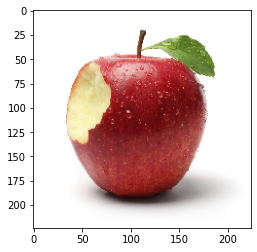

In [5]:
plt.imshow(sample_image)

In [6]:
type(sample_image)

PIL.Image.Image

In [7]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)

In [8]:
type(sample_image)

numpy.ndarray

In [9]:
np.shape(sample_image)

(224, 224, 3)

In [10]:
sample_image = np.expand_dims(sample_image, axis =0)

In [11]:
sample_image.shape

(1, 224, 224, 3)

In [12]:
sample_image.max()

255.0

In [13]:
sample_image.min()

1.0

In [14]:
train_dir = Path('/content/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))


In [15]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [16]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [17]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['pomegranate' 'potato' 'kiwi' 'carrot' 'eggplant' 'grapes' 'cabbage'
 'turnip' 'banana' 'soy beans' 'lemon' 'mango' 'pineapple' 'apple'
 'sweetpotato' 'pear' 'onion' 'peas' 'sweetcorn' 'lettuce' 'cauliflower'
 'paprika' 'garlic' 'watermelon' 'bell pepper' 'tomato' 'raddish' 'corn'
 'spinach' 'jalepeno' 'ginger' 'capsicum' 'beetroot' 'orange' 'cucumber'
 'chilli pepper']


In [18]:
train_df.head(5)

,Filepath,Label
0,/content/train/pomegranate/Image_7.jpg,pomegranate
1,/content/train/potato/Image_38.jpg,potato
2,/content/train/kiwi/Image_18.jpg,kiwi
3,/content/train/carrot/Image_53.jpg,carrot
4,/content/train/eggplant/Image_65.jpg,eggplant


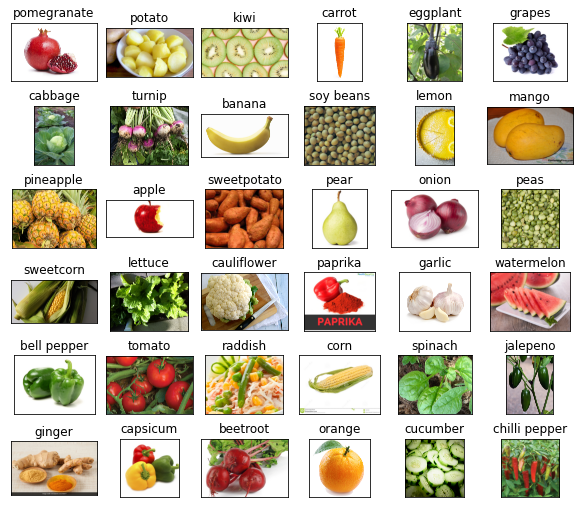

In [19]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [20]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [21]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [22]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
87/87 [==============================] - 289s 3s/step - loss: 1.7852 - accuracy: 0.5442 - val_loss: 0.4499 - val_accuracy: 0.8653
Epoch 2/5
87/87 [==============================] - 279s 3s/step - loss: 0.5996 - accuracy: 0.8122 - val_loss: 0.2792 - val_accuracy: 0.9132
Epoch 3/5
87/87 [==============================] - 268s 3s/step - loss: 0.3387 - accuracy: 0.8939 - val_loss: 0.2261 - val_accuracy: 0.9431
Epoch 4/5
87/87 [==============================] - 272s 3s/step - loss: 0.2190 - accuracy: 0.9338 - val_loss: 0.2103 - val_accuracy: 0.9222
Epoch 5/5
87/87 [==============================] - 276s 3s/step - loss: 0.1512 - accuracy: 0.9518 - val_loss: 0.1810 - val_accuracy: 0.9521
